# Summer Project - The Ising Model and The Metropolis Algorithm

Edward Alexandroff<br>
Independent Summer Project 2021

This Jupyter notebook was produced as part of an independent summer project I undertook to learn more about how Monte Carlo methods could be used in the simulation of physical systems.

(General theory and certain elements of this implementation of the metropolis algorithm draw from the general outline laid out in the following tutorial: https://www.youtube.com/watch?v=K--1hlv9yv0&ab_channel=Mr.PSolver)

### Theory

A ferromagnet is represented as a lattice of up and down (classical) spins $(\sigma = \pm 1)$, with a specific arrangment of spins constituting a specific state. These spins in some sense represent the microscopic magnetic fields of the individual atoms that, when aligned, produce the macroscopic magnetic field of a permenant magnet. The total energy of the ferromagnet in a state $\mu$ is given by 

$$ E_{\mu} = -\sum\limits_{<ij>}{J \sigma_{i} \sigma_{j}} $$

where $<ij>$ denotes a sum over the four nearest neighbors for each lattice point. That is, the contribution to the total energy is -1 when adjacent spins are aligned, and +1 when anti-aligned. Note that we divide both sides by $J$ and work with the unitless energy $E/J$ (in computation, mentions of energy refer to this untiless energy). By the condition of detailed balance, the transition probabilities between a state $\mu$ and $\nu$ are related by the relationship

$$ \frac{P(\mu \rightarrow \nu)}{P(\nu \rightarrow \mu)} = e^{-\beta \left(E_{\nu} - E_{\mu} \right)} .$$

Note again that we make use of the unitless temperature $\beta J$. The metropolis algorithm can be used to determine the ferromagnet's equilibrium position, starting from a random lattice state. First, a random spin is flipped, then the difference in energy between the new and old lattice is calculated. If the difference in energy is negative, the flip is accepted, and if the difference is positive, it is accepted with probability given by the Boltzmann factor

$$P(\mu \rightarrow \nu) = e^{-\beta \Delta E}$$

This Jupyter notebook is written more for the purpose of visualizing the Ising Model, and less for precisely investigating thermodynamic properties of the Lattice. Nonetheless, this code could be easily modified for a more thorough scientific investigation, e.g. investigation of the properties of phase transitions.

### Implementation

First, let's initialize the notebook

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib.animation import FuncAnimation, PillowWriter

Below is a function that creates a lattice, and a function capable of determining the total energy of the lattice. Note that the position of a point (x, y) on the lattice is given by lattice[y, x] and that white tiles represent an up spin, and black tiles represent a down spin.

In [4]:
def create_lattice(size, fraction_up):
    """
    produces a square lattice of dimensions [size, size], with fraction_up 
    giving the fraction of up spins
    """
    
    random_values = np.random.uniform(size=[size, size])
    lattice = np.zeros([size, size])
    
    lattice[random_values <= fraction_up] = 1
    lattice[random_values > fraction_up] = -1
    
    return lattice

def lattice_energy(lattice):
    """
    Returns energy of the entire lattice in the form E/J by convolving lattice
    with the following kernel, summing the contributions to the energy at every
    lattice point.
    """
    
    kernel = generate_binary_structure(2, 1)
    kernel[1, 1] = False

    temp = -1 * lattice * convolve(lattice, kernel, mode='constant', cval=0)
    lattice_energy = temp.sum()
    
    return lattice_energy

Below, the Metropolis Algorithm is implemented in full and a random lattice is allowed to reach an equilibrium position given some unitless temperature $\beta J$

We observe the expected behavior, namely that at high temperatures like $\beta J = 0.2$, the lattice approaches a high entropy anti-aligned state. At low temperatures like $\beta J = 0.7$, the energy approaches a minimum and the spins align towards a state dependant on the initial state. 

Wall time: 25.6 s


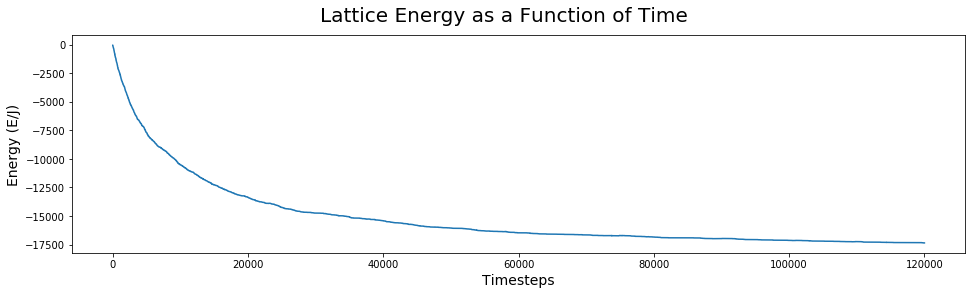

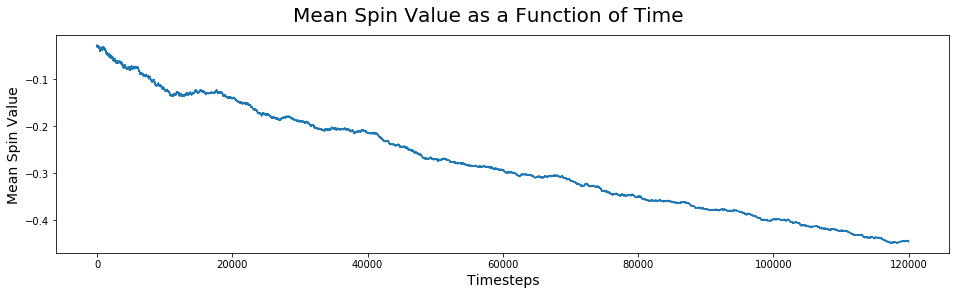

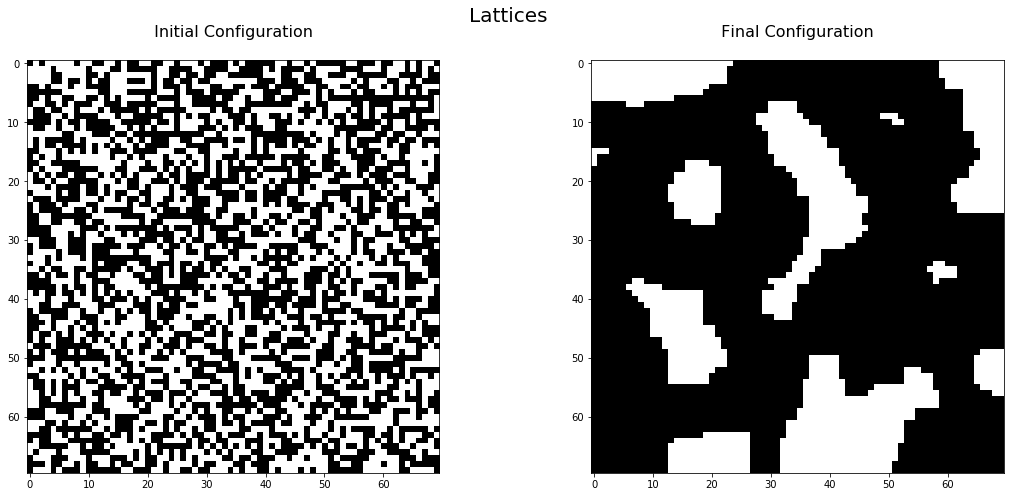

In [5]:
%%time

%matplotlib inline
%matplotlib inline

N = 70
FRACTION_UP = 0.5
NUM_TIMESTEPS = 120000
TEMP_UNITLESS = 0.7

def lattice_plotter(subplot, lattice):
    """
    Plots the lattice
    """
    
    lattice_plot = subplot.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
    
    return

def flip_spin(lattice):
    """
    flips the spin to output a new lattice and data associated with the flipped spin
    """
    
    width = len(lattice[0])
    
    x_coord = int(np.random.uniform(0, width))
    y_coord = int(np.random.uniform(0, width))
    
    lattice_flipped = np.copy(lattice)   
    
    flipped_value = -1 * lattice_flipped[y_coord, x_coord]
    lattice_flipped[y_coord, x_coord] = flipped_value

    return lattice_flipped, x_coord, y_coord, flipped_value

def test_energy(delta_E, temp_unitless):
    """
    Determines whether or not to change from the old lattice to the new lattice based off of delta_E value, as outlined 
    in the theory section. Note that scaled_temp refers to the inverse temperature times J.
    """
    
    transition = True
    if delta_E < 0:
        transition = True
    
    else:
        #generate a random number between 0 and 1 and if it falls below prob_transition, transition occurs
        #i.e. more likely to flip regardless when hotter
        
        prob_transition = np.exp(-1 * temp_unitless * delta_E)
        random = np.random.uniform(0, 1)
        
        if random < prob_transition:
            transition = True
            
        else:
            transition = False
        
    return transition

def metropolis(lattice_init, num_timesteps, temp_unitless):
    """
    the metropolis algorithm
    """
    
    lattice = lattice_init
    
    #starting book-keeping
    lattice_energy_values = np.empty(num_timesteps)
    first_energy_value = lattice_energy(lattice)
    lattice_energy_values[0] = first_energy_value
    
    mean_spin_values = np.empty(num_timesteps)
    first_mean_spin_value = np.mean(lattice)
    mean_spin_values[0] = first_mean_spin_value
    
    lattice_configurations = np.empty([num_timesteps, N, N])
    lattice_configurations[0] = lattice

    for i in range(num_timesteps - 1):
        
        #call the flip_spin function to flip a spin on the lattice and get info about it
        flip_data = np.empty(3)
        flip_data = flip_spin(lattice)
        lattice_flipped = flip_data[0]

        #determine the change in energy between the two lattices
        flipped_energy_value = lattice_energy(lattice_flipped)
        delta_E = flipped_energy_value - lattice_energy_values[i]
        
        #call the test_energy function to decide whether or not to keep the old or new lattice depending on delta_E
        transition = test_energy(delta_E, temp_unitless)
        
        #swap the lattice depending on the test outcome
        if transition == True:
            lattice = lattice_flipped  
            
            #save the already calculated energy of the flipped lattice
            lattice_energy_values[i+1] = flipped_energy_value
        else:
            
            #lattice is unchanged therefore energy is unchanged
            lattice_energy_values[i+1] = lattice_energy_values[i]
        
        #record new lattice configuration regardless of flip or not
        #(+1 since starts at 0 before the loop)
        lattice_configurations[i+1] = lattice
            
        #find and record excess number of up spins
        mean_spin = np.mean(lattice)
        mean_spin_values[i+1] = mean_spin
        
    return lattice_energy_values, mean_spin_values, lattice_configurations

#creating the initial lattice
lattice_init = create_lattice(N, FRACTION_UP)

#running the metropolis algorithm
data = metropolis(lattice_init, NUM_TIMESTEPS, TEMP_UNITLESS)

energy_values = data[0]
mean_spin_values = data[1]
lattice_configs = data[2]

lattice_final = lattice_configs[-1]

#allowing a plot against time
time_values = np.ones(NUM_TIMESTEPS)
time_values = np.cumsum(time_values)

#plotting energy against time

plt.rcParams["figure.figsize"] = (16, 4)
figure_2 = plt.figure()
figure_2.suptitle('Lattice Energy as a Function of Time', fontsize=20)

subplot = figure_2.add_subplot(111)
subplot.set_xlabel('Timesteps', fontsize=14)
subplot.set_ylabel('Energy (E/J)', fontsize=14)

subplot.plot(time_values, energy_values)

#plotting excess up-spins against time

plt.rcParams["figure.figsize"] = (16, 4)
figure_3 = plt.figure()
figure_3.suptitle('Mean Spin Value as a Function of Time', fontsize=20)

subplot_3 = figure_3.add_subplot(111)
subplot_3.set_xlabel('Timesteps', fontsize=14)
subplot_3.set_ylabel('Mean Spin Value', fontsize=14)
subplot_3.plot(time_values, mean_spin_values)

#plotting lattice configurations

plt.rcParams["figure.figsize"] = (16, 7)
figure = plt.figure()
figure.suptitle('Lattices \n', fontsize=20)

subplot_1 = figure.add_subplot(121)
subplot_1.set_title('\n Initial Configuration \n', fontsize=16)
subplot_2 = figure.add_subplot(122)
subplot_2.set_title('\n Final Configuration \n', fontsize=16)
lattice_plotter(subplot_1, lattice_init)
lattice_plotter(subplot_2, lattice_final)

plt.tight_layout()

As one would expect, the energy of the lattice decreases, and the lattice evolves towards a more ordered state. Regions within the magnet align spins to form "domains".

It's worth noting that the change in energy of a newly flipped lattice could in theory be evaluated more efficiently than by computing the energy of the whole lattice with the lattice_energy function. However, since we'll be plotting the total energy of the lattice anyway, this isn't necessary for this specific implementation.  

### Animation

Now, let's create an animation to visualize the above evolution towards an equilibrium position.

<IPython.core.display.Javascript object>


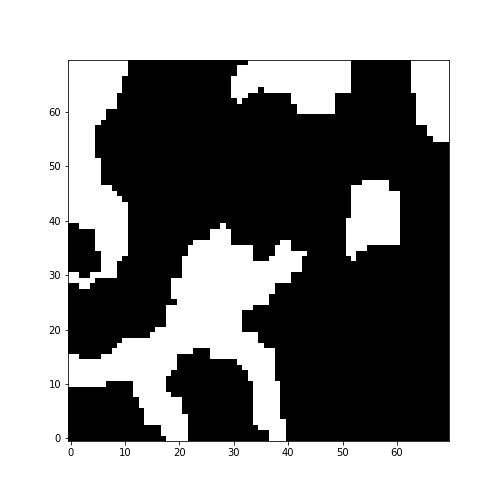

In [12]:
%matplotlib notebook
%matplotlib notebook

#fraction of total animation length for which final lattice is shown
FRAC_LENGTH = 0.15
#the interval between simulation frames shown in the animation
ANIM_INTERVAL = 13

def animation_configs(lattice_configs, frac_length, anim_interval):
    """
    Prepares the lattices for animation. frac_length determines how long the final lattice is shown at the end of the 
    animation and anim_interval allows more control over the speed of the animation by skipping fewer or more frames
    """
    
    final_lattices = np.empty([int(frac_length * NUM_TIMESTEPS), N, N])
    
    for i in range(int(frac_length * NUM_TIMESTEPS)):
        final_lattices[i] = lattice_configs[-1]

    lattice_configs = np.vstack([lattice_configs, final_lattices])
    
    new_num_frames = int(len(lattice_configs) / anim_interval)
    new_lattice_configs = np.empty([new_num_frames, N, N])
    for i in range(new_num_frames):
        new_lattice_configs[i] = lattice_configs[i * anim_interval]
    
    return new_lattice_configs

#extending the end of the animation
lattice_configs = animation_configs(lattice_configs, FRAC_LENGTH, ANIM_INTERVAL)

#the initial figure
plt.rcParams["figure.figsize"] = (7, 7)
fig = plt.figure()

#the initial plot
ax = plt.axes(xlim=(-0.5, N-0.5), ylim=(-0.5, N-0.5))

#the initial image
im = plt.imshow(lattice_configs[0], interpolation='none', cmap='gray')
    
# initialization function: plot the background of each frame
def init():
    #creating an initial image with the following data inside
    im.set_data(lattice_configs[0])
    
    return [im]

# animation function. This is called sequentially
def animate(frame_num):
    #change to a new array for each frame (as designated by the frame number)
    lattice = lattice_configs[frame_num]  

    #set the image with the new data
    im.set_array(lattice)

    return [im]

#note frames needs to be more than the number of lattices
anim = FuncAnimation(fig, animate, frames=int(NUM_TIMESTEPS * (1 + FRAC_LENGTH)/ANIM_INTERVAL), interval=1, blit=True)
#anim.save("test.gif", writer=PillowWriter(fps=60))
plt.show()

### External Magnetic Field

Now let's implement the full Ising Model, which includes an external magnetic field. Here the energy ${E_\mu}$ is given by

$$ E_{\mu} = -\sum\limits_{<ij>}{J \sigma_{i} \sigma_{j}} - \mu\sum\limits_{j}{h_j \sigma_j}$$

where $\mu_j$ is the magnetic moment of the $j$th lattice site and $h_j$ is the external magnetic field at that point (note that a positive $h$ influences the spins to align in the up direction, and a negative $h$ the down direction). From now on we'll use the unitless quantity 

$$ \gamma = \frac{\mu h}{J} $$

to quanitfy the strength of the effect of the external magnetic field. I.e. the dimensionless energy we've used thus far for computation now takes the form

$$ \frac{E_{\mu}}{J} = -\sum\limits_{<ij>}{\sigma_{i} \sigma_{j}} - \gamma\sum\limits_{j}{\sigma_j} .$$

Let's run the same simulation as above but with a non-zero $\gamma$ value. The previous simulation could of course be run as a special case of this simulation; the code above for the Ising model with no external magnetic field has been left in for posterity.

Let's run the simulation at an inverse unitless temperature of $\beta J=0.2$. As remarked earlier, in the case of no external magnetic field, this temperature would be high enough for the ferromagnet to have difficulty achieving an aligned, ordered state. However, when a sufficiently strong external magnetic field is present, say $\gamma=-1.5$, the spins are "forced" to align.

Traceback (most recent call last):
  File "C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


Wall time: 21.8 s


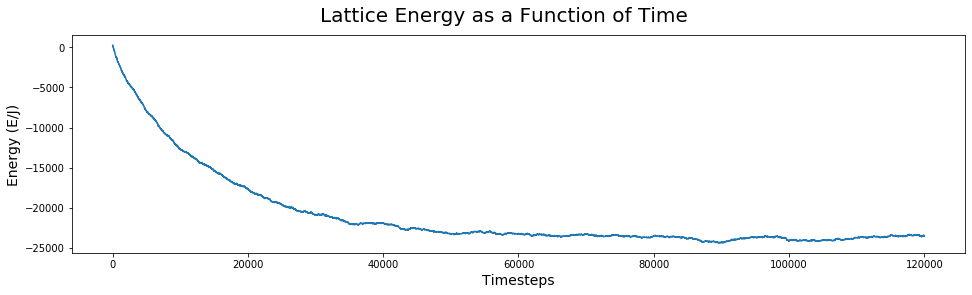

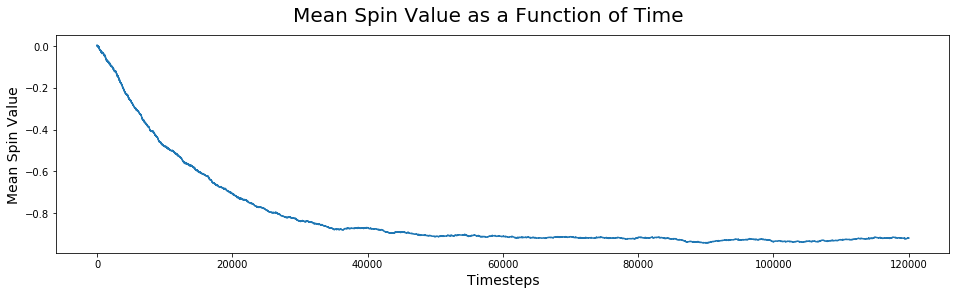

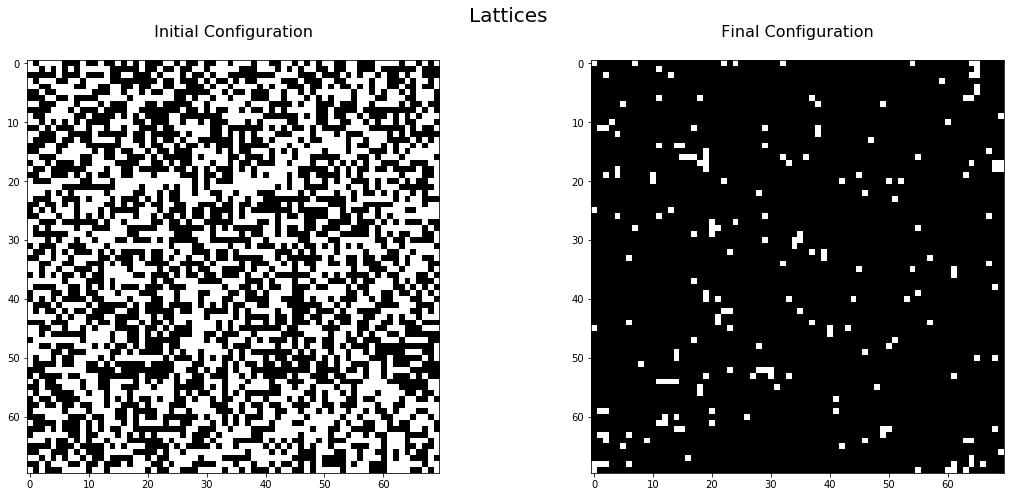

In [17]:
%%time

%matplotlib inline
%matplotlib inline

N = 70
FRACTION_UP = 0.5
NUM_TIMESTEPS = 120000
TEMP_UNITLESS = 0.2
GAMMA = -1.5

def lattice_energy_2(lattice, gamma):
    """
    Returns energy of the entire lattice in the form E/J, now taking into account interaction with the external field
    """
    #convolves a kernel with the lattice to give the total lattice energy
    kernel = generate_binary_structure(2, 1)
    kernel[1, 1] = False

    temp = -1 * lattice * convolve(lattice, kernel, mode='constant', cval=0)
    lattice_energy = temp.sum()
    
    #taking into account the external field
    field_contribution = -1 * gamma * lattice.sum()
    lattice_energy = lattice_energy + field_contribution
    
    return lattice_energy

def metropolis_2(lattice_init, num_timesteps, temp_unitless, gamma):
    """
    the metropolis algorithm
    """
    
    lattice = lattice_init
    
    #starting book-keeping
    lattice_energy_values = np.empty(num_timesteps)
    first_energy_value = lattice_energy_2(lattice, gamma)
    lattice_energy_values[0] = first_energy_value
    
    mean_spin_values = np.empty(num_timesteps)
    first_mean_spin_value = np.mean(lattice)
    mean_spin_values[0] = first_mean_spin_value
    
    lattice_configurations = np.empty([num_timesteps, N, N])
    lattice_configurations[0] = lattice

    for i in range(num_timesteps - 1):
        
        #call the flip_spin function to flip a spin on the lattice and get info about it
        flip_data = np.empty(3)
        flip_data = flip_spin(lattice)
        lattice_flipped = flip_data[0]

        #determine the change in energy between the two lattices
        flipped_energy_value = lattice_energy_2(lattice_flipped, gamma)
        delta_E = flipped_energy_value - lattice_energy_values[i]
        
        #call the test_energy function to decide whether or not to keep the old or new lattice depending on delta_E
        transition = test_energy(delta_E, temp_unitless)
        
        #swap the lattice depending on the test outcome
        if transition == True:
            lattice = lattice_flipped  
            
            #save the already calculated energy of the flipped lattice
            lattice_energy_values[i+1] = flipped_energy_value
        else:
            
            #lattice is unchanged therefore energy is unchanged
            lattice_energy_values[i+1] = lattice_energy_values[i]
        
        #record new lattice configuration regardless of flip or not
        #(+1 since starts at 0 before the loop)
        lattice_configurations[i+1] = lattice
            
        #find and record excess number of up spins
        mean_spin = np.mean(lattice)
        mean_spin_values[i+1] = mean_spin
        
    return lattice_energy_values, mean_spin_values, lattice_configurations

#creating the initial lattice
lattice_init = create_lattice(N, FRACTION_UP)

#running the metropolis algorithm
data = metropolis_2(lattice_init, NUM_TIMESTEPS, TEMP_UNITLESS, GAMMA)

energy_values = data[0]
mean_spin_values = data[1]
lattice_configs = data[2]

lattice_final = lattice_configs[-1]

#allowing a plot against time
time_values = np.ones(NUM_TIMESTEPS)
time_values = np.cumsum(time_values)

#plotting energy against time

plt.rcParams["figure.figsize"] = (16, 4)
figure_4 = plt.figure()
figure_4.suptitle('Lattice Energy as a Function of Time', fontsize=20)

subplot_ext_1 = figure_4.add_subplot(111)
subplot_ext_1.set_xlabel('Timesteps', fontsize=14)
subplot_ext_1.set_ylabel('Energy (E/J)', fontsize=14)

subplot_ext_1.plot(time_values, energy_values)

#plotting excess up-spins against time

plt.rcParams["figure.figsize"] = (16, 4)
figure_5 = plt.figure()
figure_5.suptitle('Mean Spin Value as a Function of Time', fontsize=20)

subplot_ext_2 = figure_5.add_subplot(111)
subplot_ext_2.set_xlabel('Timesteps', fontsize=14)
subplot_ext_2.set_ylabel('Mean Spin Value', fontsize=14)
subplot_ext_2.plot(time_values, mean_spin_values)

#plotting lattice configurations

plt.rcParams["figure.figsize"] = (16, 7)
figure_6 = plt.figure()
figure_6.suptitle('Lattices \n', fontsize=20)

subplot_7 = figure_6.add_subplot(121)
subplot_7.set_title('\n Initial Configuration \n', fontsize=16)
subplot_8 = figure_6.add_subplot(122)
subplot_8.set_title('\n Final Configuration \n', fontsize=16)
lattice_plotter(subplot_7, lattice_init)
lattice_plotter(subplot_8, lattice_final)

plt.tight_layout()

### Animation

Let's create an animation for this transition as well

Traceback (most recent call last):
  File "C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


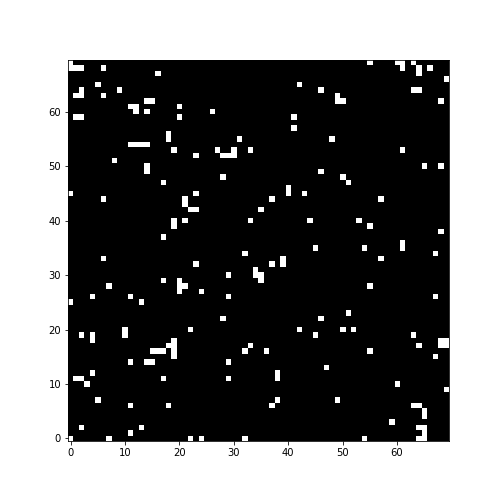

In [19]:
%matplotlib notebook
%matplotlib notebook

#extending the end of the animation
lattice_configs = animation_configs(lattice_configs, FRAC_LENGTH, ANIM_INTERVAL)

#the initial figure
plt.rcParams["figure.figsize"] = (7, 7)
fig = plt.figure()

#the initial plot
ax = plt.axes(xlim=(-0.5, N-0.5), ylim=(-0.5, N-0.5))

#the initial image
im = plt.imshow(lattice_configs[0], interpolation='none', cmap='gray')
    
# initialization function: plot the background of each frame
def init():
    #creating an initial image with the following data inside
    im.set_data(lattice_configs[0])
    
    return [im]

# animation function. This is called sequentially
def animate(frame_num):
    #change to a new array for each frame (as designated by the frame number)
    lattice = lattice_configs[frame_num]  

    #set the image with the new data
    im.set_array(lattice)

    return [im]

#note: frames needs to be more than the number of lattices
anim = FuncAnimation(fig, animate, frames=int(NUM_TIMESTEPS * (1 + FRAC_LENGTH)/ANIM_INTERVAL), interval=1, blit=True)

#save the animation as a gif
#anim.save("test.gif", writer=PillowWriter(fps=60))
plt.show()